# Profiling and optimization information out of BigDFT runs

In this notebook we will provide an exmaple of the analysis of runs coming from BigDFT.
The idea is to give the user some informations about:
* Understand if everything is OK during the run
* Identify potential bottlenecks and hot-spot operations
* Undestand the performance gain the user might have in optimizing some section of the code from an *algorithm* point of view

## First example: regular code, bandwidth saturation 

To start let us load the data of a run coming from a Graphene BigDFT calculation on ARM Architecture (MontBlanc prototype, run of few years ago):

In [1]:
from futile import Time
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Strong scaling analysis
We analyse a series of runs with different values of the MPI tasks; we might have access first to the speedup:

In [1]:
a=('time-16.yaml','time-32.yaml','time-41.yaml','time-82.yaml','time-164.yaml','time-656.yaml')
files=['testfiles/'+f for f in a]

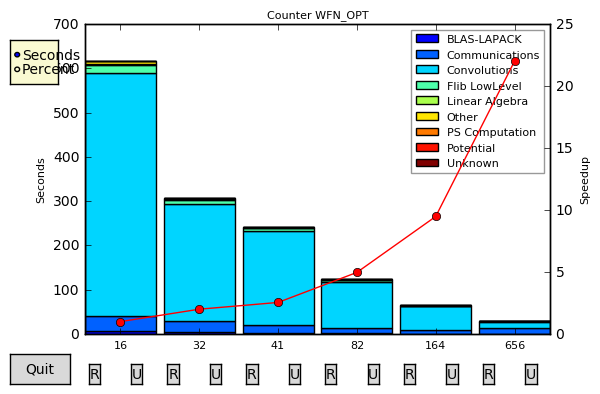

In [3]:
strongscalingsec=Time.TimeData(*files,fontsize=8)

Then to the parallel efficiency. With this plot we immediately realize that the run with 656 MPI tasks saturates the network bandwidth of the machine:

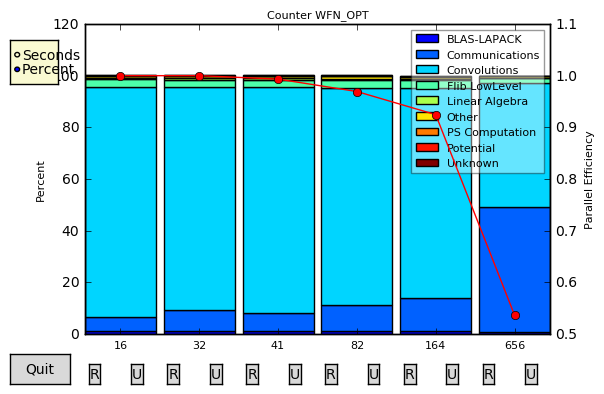

In [4]:
strongscalingprc=Time.TimeData(*files,fontsize=8,plottype='Percent')

### Behaviour of the "Communications" category
This is confirmed by the separate inspection of the Communications category, where we see that *all* the different routines have a performance loss:

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


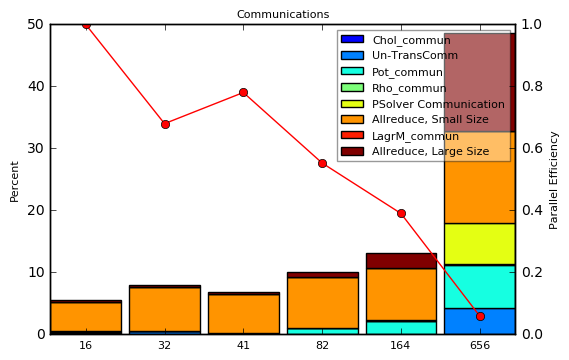

In [5]:
strongscalingprc.inspect_category('Communications')

### Detection of unbalancing problems
In addition, we might inspect with this run that for the smallest run there has been a *unexpected* behaviour of the machine: indeed, even though the data are evenly distributed, some nodes exhibit a uneven workload. This observation lead us to the detection of some configuration problems in the corresponding nodes, thereby helping system's administrators.

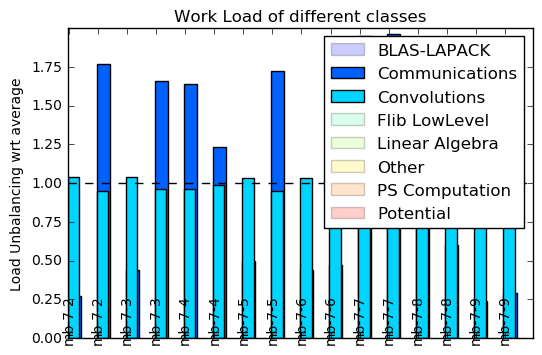

In [6]:
strongscalingprc.workload_plot(0)

### Algorithm analysis: the influence of the Preconditioning
Apart from the behaviour of the machine, we have seen that the Convolutions category contains the hot-spot operations of the run. We might inspect it more carefully:

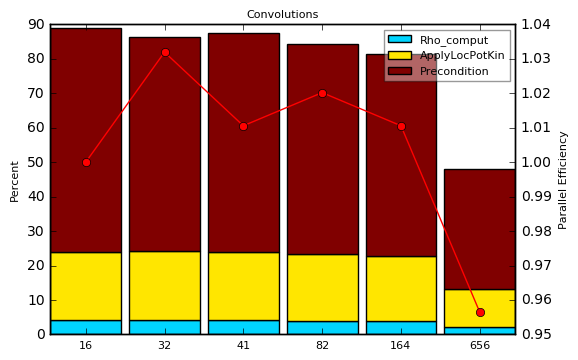

In [7]:
strongscalingprc.inspect_category('Convolutions')

Here we see that for all the runs (except the one where communications saturate) the Preconditioning operation is taking more than 70% of the total walltime.
According to these results the uset might decide to loosen the preconditioning scheme, and use a lighter one. According to these data such modification of the input file will results in lower walltime, providing that the number of SCF iteration will not increase more than 2.5 times.

### Exercise: Inspect the same performances interactively.
Run the same analysis within the interactive scheme as it is shown in the PerformanceInvestigations.ipynb notebook.

In [3]:
%matplotlib qt

In [4]:
from futile import Time
Time.TimeData(*files).show()

Good bye!


## Second example: same system with cubic and linear scaling codes

Let us now consider two runs with similar systems, performed with the cubic scaling and the linar scaling BigDFT code. We consider two DNA-based runs with more than two thousands atoms.
We see that the O(N) approach is more than three times faster even though the number of atoms is 30% bigger:

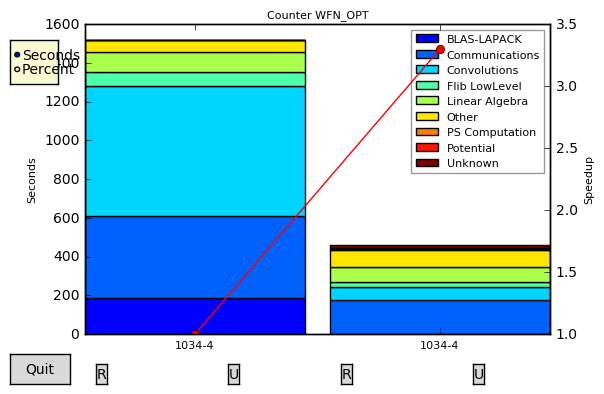

In [5]:
#inline or qt
%matplotlib inline
b=('testfiles/time_2145.yaml','testfiles/time_2860.yaml')
linvscubic=Time.TimeData(*b,fontsize=8)
#linvscubic.show()

We may also see that the repartition of the operations is completely different: in the O(N) approach there is not anymore a hot-spot computational operation, communication is in this case the most important part. Still, the entire category is composed by lots of small operations:

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


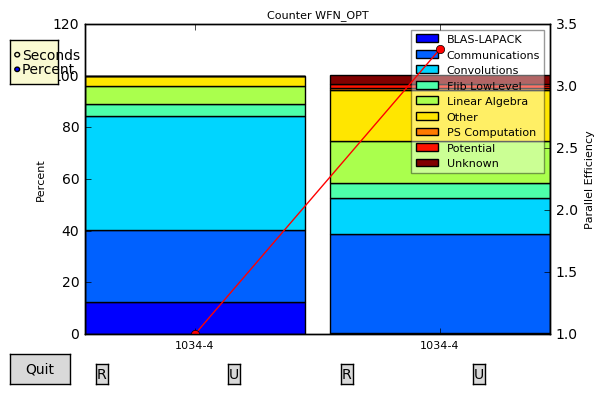

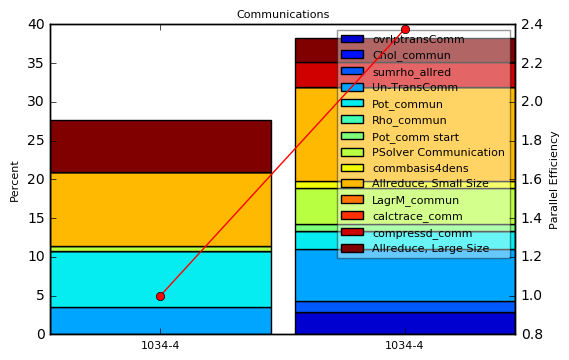

In [6]:
linvscubicprc=Time.TimeData(*b,fontsize=8,plottype='Percent')
linvscubicprc.inspect_category('Communications')

### Understanding how to increase performance: fixing the basis set.
With such a scenario, it would be extremely difficult to have a further gain in walltime by optimizing kernels or with the same strategy as the cubic code.
However we might observe how the linear scaling run behaves in terms of the _routines_ which are considered:

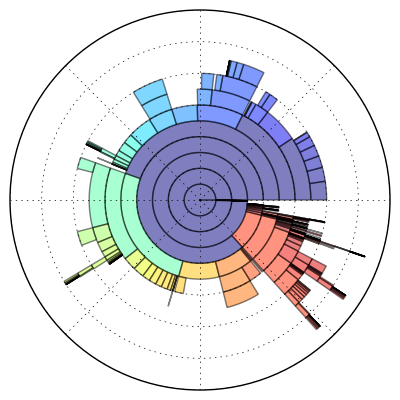

In [7]:
linvscubicprc.routines_plot(1)

The fifth level of the routines (from the innermost circle) represents the two phases of the outer SCF loop: the determnation of the basis set (dark blue) as well as the determination of the coefficients with fixed basis (light water green). As the procedure of the determination of the basis set consists in about a half ot the overall walltime, it might be convenient to employ fixed basis sets for similar systems, providing that the loss in accuracy is not too severe.

#### Exercise: try again to analyse the routines plot with the interactive matplotlib widgets mode.
To which percentage of the run the get_locbasis routine would correspond (hint: pass with the mouse pointer over the different areas in the polar plot)

### Behaviour with larger systems
We also notice, in passing, that the proposed analysis seems to be valid also for a wide range of systems sizes:

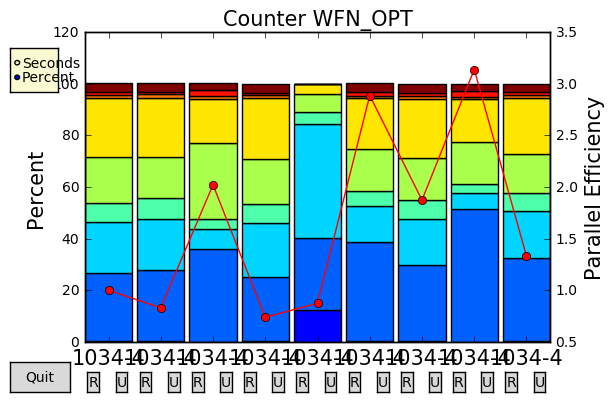

In [8]:
c=!ls testfiles/time_*
allruns=Time.TimeData(*c,plottype='Percent',nokey=True)